<a href="https://colab.research.google.com/github/marcinwolter/RATS/blob/main/Keras_DEC_RATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to do Unsupervised Clustering with Keras](https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/) | DLology

Modified version of:

https://github.com/Mboga/Keras_Deep_Clustering/blob/master/Keras-DEC.ipynb

In [1]:
from keras.datasets import mnist
import numpy as np
np.random.seed(10)

In [2]:
from time import time
import numpy as np
import keras.backend as K
from tensorflow.python.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import sklearn.metrics



In [3]:

def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x = np.concatenate((x_train, x_test))
#y = np.concatenate((y_train, y_test))
x_train = x_train.reshape((x_train.shape[0], -1))
x_train = np.divide(x_train, 255.)
x_test = x_test.reshape((x_test.shape[0], -1))
x_test = np.divide(x_test, 255.)

11490434/11490434 [==============================] - 2s 0us/step


In [5]:
n_clusters = len(np.unique(y_train))
print("n_clusters = ",n_clusters)
print("x_train shae: ",x_train.shape)
print("x_test shape: ",x_test.shape)

n_clusters =  10
x_train shae:  (60000, 784)
x_test shape:  (10000, 784)


## Base line K-Means clustering accuracy

In [6]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20).fit(x_train)
y_pred_kmeans = kmeans.predict(x_test)

In [7]:
sklearn.metrics.rand_score(y_test, y_pred_kmeans)

0.880267406740674

## Hyper-params

In [8]:
dims = [x_train.shape[-1], 500, 500, 2000, 10]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = '.'

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [9]:
autoencoder, encoder = autoencoder(dims, init=init)

autoencoder.summary()
encoder.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 500)               1000500  

In [10]:
'''
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='autoencoder.png')
''' 

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)\nfrom IPython.display import Image\nImage(filename='autoencoder.png')\n"

In [11]:
'''
from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='encoder.png', show_shapes=True)
from IPython.display import Image
Image(filename='encoder.png') 
'''

"\nfrom tensorflow.keras.utils import plot_model\nplot_model(encoder, to_file='encoder.png', show_shapes=True)\nfrom IPython.display import Image\nImage(filename='encoder.png') \n"

## Pretrain auto-encoder

In [12]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x_train, x_train, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300
235/235 [==============================] - 4s 5ms/step - loss: 0.0656
Epoch 2/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0447
Epoch 3/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0332
Epoch 4/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0276
Epoch 5/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0249
Epoch 6/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0233
Epoch 7/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0220
Epoch 8/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0211
Epoch 9/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0203
Epoch 10/300
235/235 [==============================] - 1s 4ms/step - loss: 0.0197
Epoch 11/300
235/235 [==============================] - 1s 6ms/step - loss: 0.0191
Epoch 12/300
235/235 [==============================] - 1s 5ms/step - loss: 0.0186
Epoch 13/300


In [13]:
#autoencoder.save_weights(save_dir + '/ae_weights.h5')

### Load the pre-trained auto encoder weights

In [14]:
#autoencoder.load_weights(save_dir + '/ae_weights.h5')

## Build clustering model

In [16]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20).fit(encoder.predict(x_train))
y_pred = kmeans.predict(encoder.predict(x_test))
print("rand_score = ",sklearn.metrics.rand_score(y_test,y_pred))

313/313 [==============================] - 0s 1ms/step
rand_score =  0.9558012601260126


# Find confusion matrix

In [17]:
# Preparation - find corresponding true and cluster labels

y_matched = np.empty_like(y_pred)

# For each cluster label...
for k in np.unique(y_pred):

    # ...find and assign the best-matching truth label
    match_nums = [np.sum((y_pred==k)*(y_test==t)) for t in np.unique(y_test)]
    y_matched[y_pred==k] = np.unique(y_test)[np.argmax(match_nums)]

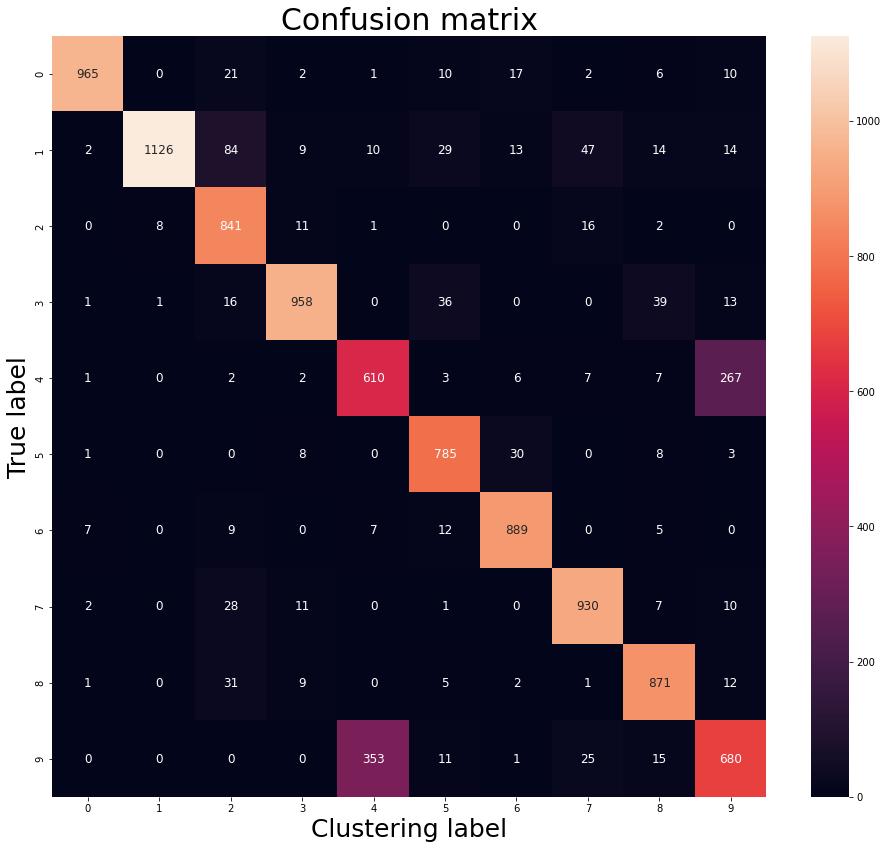

In [18]:
# Plot the confusion matrix

import matplotlib.pyplot as plt
import seaborn as sns


confusion_matrix = sklearn.metrics.confusion_matrix(y_matched, y_test)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 12});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

1875/1875 [==============================] - 3s 1ms/step
(60000, 10)


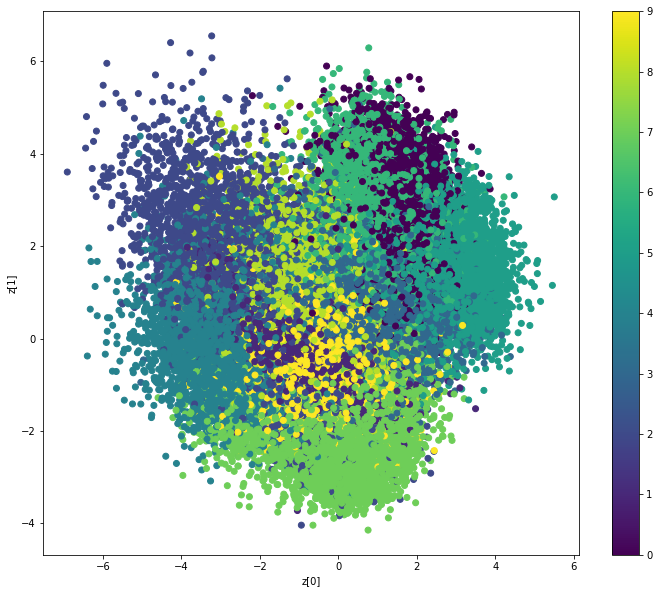

In [19]:
import matplotlib.pyplot as plt

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = vae.predict(data.reshape(len(data),784))
    print(z_mean.shape)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)